# Dependencies

In [1]:
!pip install seaborn matplotlib pandas numpy

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# Experiment 1: The Effect of Training Steps and Model Size on MSA

In [4]:
def load_msa_experiment_data():
    """
    Load MSA training results similar to original experiment 1 format
    Combines Whisper model sizes with MSA training steps data
    """
    # Load Whisper model sizes from original experiment
    root = "results/ex_trainsize/"
    data = {}
    
    # Load Whisper model results (these represent 0% additional MSA training - baseline)
    whisper_models = ["whisper-tiny", "whisper-base", "whisper-small", "whisper-medium", "whisper-large-v3"]
    
    for model in whisper_models:
        model_data = {}
        seeds = []
        
        # Try to load all available seeds for this model
        for seed in [42, 84, 168]:
            file_path = os.path.join(root, f"results_common_voice_{model}_seed{seed}.json")
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    result = json.load(f)
                    model_data[f"{model}_seed{seed}"] = result
                    seeds.append(seed)
        
        # If no seed files exist, try without seed
        if not seeds:
            file_path = os.path.join(root, f"results_common_voice_{model}.json")
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    result = json.load(f)
                    model_data[f"{model}_seed42"] = result
                    seeds = [42]
        
        if seeds:
            data.update(model_data)
    
    # Load full fine-tuning data (1.0 - 100% full fine-tuning) from original experiment 1
    for seed in [42, 84, 168]:
        file_path = os.path.join(root, f"results_common_voice_1.0_seed{seed}.json")
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                result = json.load(f)
                data[f"1.0_seed{seed}"] = result
    
    # Load MSA training steps data (3K and 6K steps)
    msa_path = "notebook/msa_results"
    msa_steps = [3000, 6000]
    
    for steps in msa_steps:
        file_path = os.path.join(msa_path, f"results_whisper-small-peft_msa_{steps}.json")
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                msa_result = json.load(f)
                # Convert to match original format
                converted_result = {
                    'eval_wer': msa_result['wer'],
                    'eval_cer': msa_result['cer'],
                    'eval_loss': msa_result['final_loss'],
                    'eval_runtime': msa_result['training_time_seconds'],
                    'eval_samples_per_second': 0.0,
                    'eval_steps_per_second': 0.0
                }
                # Add for multiple seeds (using same result for consistency)
                for seed in [42, 84, 168]:
                    data[f"{steps}_steps_seed{seed}"] = converted_result
    
    # Create DataFrame similar to original
    df_msa_experiment = pd.DataFrame(data).drop(["eval_samples_per_second", "eval_steps_per_second", "eval_runtime", "eval_loss"])
    
    # Calculate mean ± std for each configuration
    configs = whisper_models + ["1.0", "3000_steps", "6000_steps"]
    
    for config in configs:
        if config in whisper_models:
            # For Whisper models, look for seed files
            config_cols = [col for col in df_msa_experiment.columns if col.startswith(f"{config}_seed")]
        else:
            # For MSA steps
            config_cols = [col for col in df_msa_experiment.columns if col.startswith(f"{config}_seed")]
        
        if len(config_cols) > 0:
            mean = df_msa_experiment[config_cols].mean(axis=1)
            std = df_msa_experiment[config_cols].std(axis=1)
            df_msa_experiment[config] = [f"{m:.2f} ± {s:.2f}" for m, s in zip(mean, std)]
    
    # Clean up and reorder
    final_configs = [config for config in configs if config in df_msa_experiment.columns]
    df_msa_experiment = df_msa_experiment[final_configs].T
    
    # Rename for better display
    rename_dict = {
        "whisper-small": "whisper\nsmall (baseline)",
        "whisper-base": "whisper\nbase", 
        "whisper-tiny": "whisper\ntiny",
        "whisper-medium": "whisper\nmedium", 
        "1.0": "Full Fine-tuning",
        "3000_steps": "3K steps\n(MSA LoRA)",
        "6000_steps": "6K steps\n(MSA LoRA)",
        "whisper-large-v3": "whisper\nlarge-v3"
        
    }
    
    df_msa_experiment.rename(index=rename_dict, inplace=True)
    df_msa_experiment.rename(columns={"eval_wer": "WER", "eval_cer": "CER"}, inplace=True)
    
    # Sort by WER mean values (descending - worst performance first, largest to smallest)
    if 'WER' in df_msa_experiment.columns:
        # Extract WER mean values for sorting
        wer_means = df_msa_experiment['WER'].apply(
            lambda x: float(x.split(" ± ")[0]) if isinstance(x, str) and " ± " in x else float(x)
        )
        # Sort by WER mean (descending - largest to smallest)
        sort_order = wer_means.argsort()[::-1]  # Reverse for descending order
        df_msa_experiment = df_msa_experiment.iloc[sort_order]
    
    return df_msa_experiment

# Load the data
df_msa_experiment = load_msa_experiment_data()
print("MSA Experiment Data (Model Sizes + Training Steps):")
df_msa_experiment

MSA Experiment Data (Model Sizes + Training Steps):


,WER,CER
whisper\ntiny,101.05 ± 0.28,54.56 ± 0.21
whisper\nbase,95.92 ± 1.26,49.97 ± 1.00
whisper\nsmall (baseline),61.93 ± 0.39,26.83 ± 0.29
whisper\nmedium,52.84 ± 0.25,22.25 ± 0.24
3K steps\n(MSA LoRA),50.27 ± 0.00,21.78 ± 0.00
6K steps\n(MSA LoRA),46.55 ± 0.00,19.13 ± 0.00
Full Fine-tuning,45.93 ± 0.12,20.11 ± 0.10
whisper\nlarge-v3,43.20 ± 0.16,16.90 ± 0.10


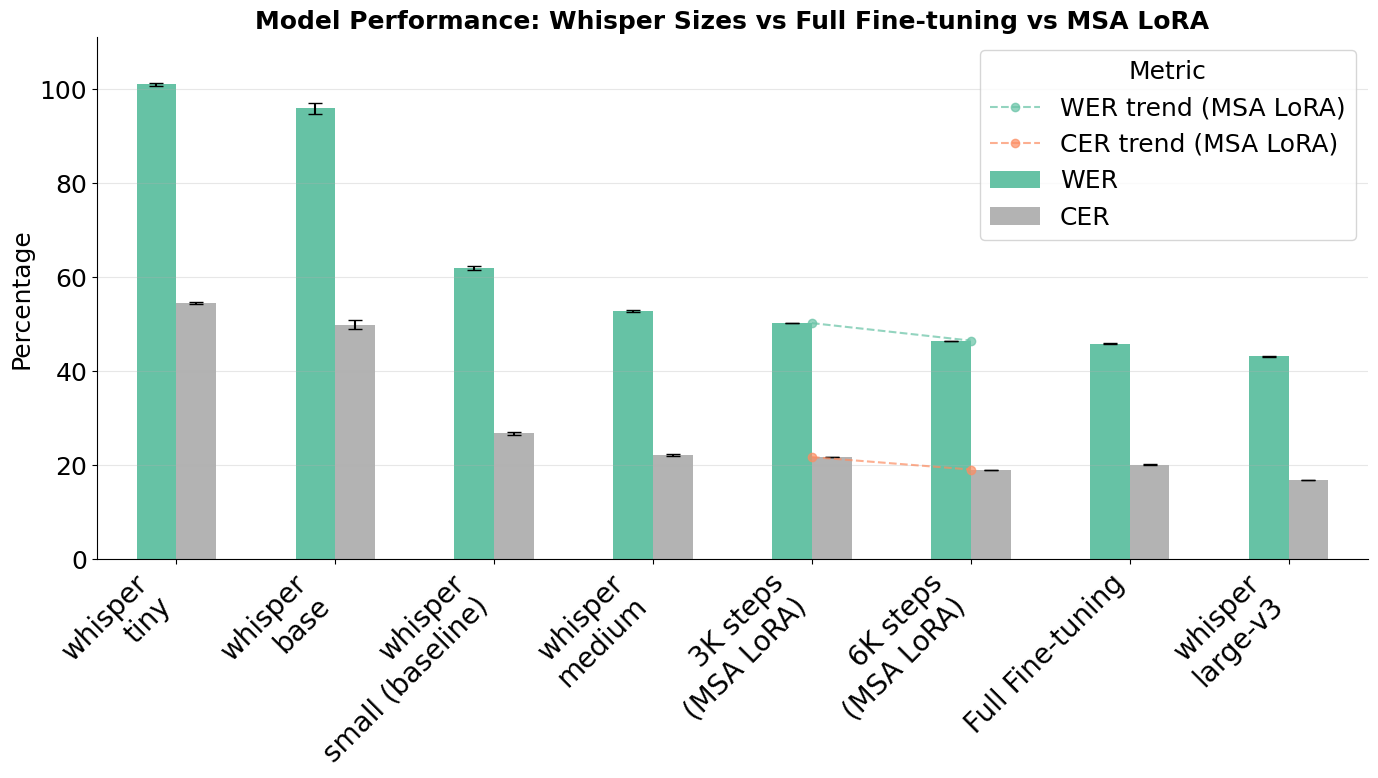


Experiment Summary (sorted by WER: largest to smallest):
Worst performer: whisper
tiny - WER: 101.05%
Best performer: whisper
large-v3 - WER: 43.20%
Performance gap: 57.85 percentage points

MSA LoRA vs Baseline Comparison:
• WER improvement (whisper
small (baseline) → 6K steps
(MSA LoRA)): 15.38 percentage points
• CER improvement (whisper
small (baseline) → 6K steps
(MSA LoRA)): 7.70 percentage points

Full Fine-tuning vs Baseline Comparison:
• WER improvement (whisper
small (baseline) → Full Fine-tuning): 16.00 percentage points
• CER improvement (whisper
small (baseline) → Full Fine-tuning): 6.72 percentage points

Full Fine-tuning vs Best MSA LoRA Comparison:
• WER difference (Full Fine-tuning vs 6K steps
(MSA LoRA)): -0.62 percentage points
• CER difference (Full Fine-tuning vs 6K steps
(MSA LoRA)): 0.98 percentage points
  → Full fine-tuning performs 0.62 WER points better

Training Steps Comparison:
• WER improvement (3K → 6K steps): 3.72 percentage points
• CER improvement (3

In [11]:
# Create the visualization similar to original experiment 1
def plot_msa_experiment_results(df_msa_experiment):
    """
    Plot results similar to original experiment 1 with model sizes and MSA training steps
    Data is already sorted by WER performance in the input DataFrame
    """
    # Extract means and standard deviations
    means = df_msa_experiment.map(lambda x: float(x.split(" ± ")[0]) if isinstance(x, str) and " ± " in x else float(x))
    stds = df_msa_experiment.map(lambda x: float(x.split(" ± ")[1]) if isinstance(x, str) and " ± " in x else 0.0)

    # Set larger font sizes globally
    plt.rcParams.update({'font.size': 14})
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot bars with error bars (data is already sorted by WER performance)
    means.plot(kind='bar', yerr=stds, ax=ax, rot=45, colormap='Set2', capsize=5, stacked=False)
    
    # Add trend lines for MSA training steps if they exist
    # Find MSA training steps in the sorted data (but not full fine-tuning)
    msa_indices = []
    for i, idx in enumerate(means.index):
        if 'MSA LoRA' in str(idx):
            msa_indices.append(i)
    
    if len(msa_indices) >= 2:
        colors = plt.cm.Set2([0, 1])  # Get colors for WER and CER
        
        for i, col in enumerate(means.columns):
            msa_x = msa_indices
            msa_y = [means[col].iloc[idx] for idx in msa_indices]
            ax.plot(msa_x, msa_y, marker='o', linestyle='--', 
                   label=f'{col} trend (MSA LoRA)', alpha=0.7, color=colors[i])

    # Styling with larger fonts
    sns.despine()
    plt.ylabel("Percentage", fontsize=18)
    plt.title("Model Performance: Whisper Sizes vs Full Fine-tuning vs MSA LoRA", fontweight='bold', fontsize=18)
    plt.legend(title="Metric", fontsize=18, title_fontsize=18)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=18)

    # Set y-axis range
    plt.ylim(0, max(means.max().max(), 100) + 10)
    
    plt.tight_layout()
    plt.savefig("msa_experiment_comparison.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nExperiment Summary (sorted by WER: largest to smallest):")
    print("="*60)
    
    # Show worst and best performers (switched due to descending order)
    worst_model = means.index[0]  # First in descending sorted order (highest WER)
    best_model = means.index[-1]  # Last in descending sorted order (lowest WER)
    
    worst_wer = means.loc[worst_model, "WER"]
    best_wer = means.loc[best_model, "WER"]
    
    print(f"Worst performer: {worst_model} - WER: {worst_wer:.2f}%")
    print(f"Best performer: {best_model} - WER: {best_wer:.2f}%")
    print(f"Performance gap: {worst_wer - best_wer:.2f} percentage points")
    
    # Compare baseline whisper-small with best models
    baseline_key = None
    best_msa_key = None
    full_finetune_key = None
    
    for idx in means.index:
        if 'baseline' in str(idx).lower():
            baseline_key = idx
        elif 'Full Fine-tuning' in str(idx):
            full_finetune_key = idx
    
    # Find best MSA model (lowest WER) - will be last in descending sorted order
    for idx in reversed(means.index):  # Check from end since we want the best (lowest WER)
        if 'MSA LoRA' in str(idx):
            best_msa_key = idx
            break
    
    if baseline_key and best_msa_key:
        baseline_wer = means.loc[baseline_key, "WER"]
        best_msa_wer = means.loc[best_msa_key, "WER"]
        wer_improvement = baseline_wer - best_msa_wer
        
        baseline_cer = means.loc[baseline_key, "CER"]
        best_msa_cer = means.loc[best_msa_key, "CER"]
        cer_improvement = baseline_cer - best_msa_cer
        
        print(f"\nMSA LoRA vs Baseline Comparison:")
        print(f"• WER improvement ({baseline_key} → {best_msa_key}): {wer_improvement:.2f} percentage points")
        print(f"• CER improvement ({baseline_key} → {best_msa_key}): {cer_improvement:.2f} percentage points")
    
    # Compare full fine-tuning with baseline and best MSA model
    if baseline_key and full_finetune_key:
        baseline_wer = means.loc[baseline_key, "WER"]
        full_finetune_wer = means.loc[full_finetune_key, "WER"]
        wer_improvement_full = baseline_wer - full_finetune_wer
        
        baseline_cer = means.loc[baseline_key, "CER"]
        full_finetune_cer = means.loc[full_finetune_key, "CER"]
        cer_improvement_full = baseline_cer - full_finetune_cer
        
        print(f"\nFull Fine-tuning vs Baseline Comparison:")
        print(f"• WER improvement ({baseline_key} → {full_finetune_key}): {wer_improvement_full:.2f} percentage points")
        print(f"• CER improvement ({baseline_key} → {full_finetune_key}): {cer_improvement_full:.2f} percentage points")
    
    # Compare full fine-tuning with best MSA LoRA model
    if full_finetune_key and best_msa_key:
        full_finetune_wer = means.loc[full_finetune_key, "WER"]
        best_msa_wer = means.loc[best_msa_key, "WER"]
        wer_diff = full_finetune_wer - best_msa_wer
        
        full_finetune_cer = means.loc[full_finetune_key, "CER"]
        best_msa_cer = means.loc[best_msa_key, "CER"]
        cer_diff = full_finetune_cer - best_msa_cer
        
        print(f"\nFull Fine-tuning vs Best MSA LoRA Comparison:")
        print(f"• WER difference ({full_finetune_key} vs {best_msa_key}): {wer_diff:.2f} percentage points")
        print(f"• CER difference ({full_finetune_key} vs {best_msa_key}): {cer_diff:.2f} percentage points")
        if wer_diff < 0:
            print(f"  → Full fine-tuning performs {abs(wer_diff):.2f} WER points better")
        else:
            print(f"  → MSA LoRA performs {wer_diff:.2f} WER points better")
    
    # Compare 3K vs 6K steps if both exist
    steps_3k_key = None
    steps_6k_key = None
    
    for idx in means.index:
        if '3K steps' in str(idx):
            steps_3k_key = idx
        elif '6K steps' in str(idx):
            steps_6k_key = idx
    
    if steps_3k_key and steps_6k_key:
        steps_3k_wer = means.loc[steps_3k_key, "WER"]
        steps_6k_wer = means.loc[steps_6k_key, "WER"]
        steps_improvement_wer = steps_3k_wer - steps_6k_wer
        
        steps_3k_cer = means.loc[steps_3k_key, "CER"]
        steps_6k_cer = means.loc[steps_6k_key, "CER"]
        steps_improvement_cer = steps_3k_cer - steps_6k_cer
        
        print(f"\nTraining Steps Comparison:")
        print(f"• WER improvement (3K → 6K steps): {steps_improvement_wer:.2f} percentage points")
        print(f"• CER improvement (3K → 6K steps): {steps_improvement_cer:.2f} percentage points")

# Create the plot
plot_msa_experiment_results(df_msa_experiment)

# Experiment 2: Comparison with and without pre-training (PEFT Models)

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

def load_peft_results(notebook_path, with_msa=True, format=True):
    """
    Load PEFT results from notebook structure
    """
    dialects = ['egyptian', 'gulf', 'levantine', 'maghrebi', 'iraqi']  
    all_data = []
    
    for dialect in dialects:
        dialect_path = os.path.join(notebook_path, f"{dialect}_results")
        if not os.path.exists(dialect_path):
            continue
            
        # Determine model suffix based on MSA usage
        model_suffix = f"{dialect}-msa" if with_msa else f"{dialect}-base"
        
        # Load results for each seed
        for seed in [42, 84, 168]:
            # Main model results
            result_file = f"results_whisper-small-peft_{model_suffix}_seed{seed}.json"
            result_path = os.path.join(dialect_path, result_file)
            
            if not os.path.exists(result_path):
                continue
                
            with open(result_path, 'r') as f:
                main_result = json.load(f)
            
            # Create row data starting with same-dialect performance
            row_data = {
                'model': f"{dialect.title()}{seed}",
                'eval_wer': {},
                'eval_cer': {}
            }
            
            # Add same dialect results
            row_data['eval_wer'][dialect.title()] = main_result['wer']
            row_data['eval_cer'][dialect.title()] = main_result['cer']
            
            # Load cross-evaluation results
            for target_dialect in dialects:
                if target_dialect == dialect:
                    continue  # Already handled above
                    
                # Cross-evaluation file naming
                cross_file_prefix = f"{dialect}-msa" if with_msa else dialect
                cross_file = f"{cross_file_prefix}_{seed}_on_{target_dialect}.json"
                cross_path = os.path.join(dialect_path, cross_file)
                
                if os.path.exists(cross_path):
                    with open(cross_path, 'r') as f:
                        cross_data = json.load(f)
                        row_data['eval_wer'][target_dialect.title()] = cross_data['eval/wer']
                        row_data['eval_cer'][target_dialect.title()] = cross_data['eval/cer']
            
            all_data.append(row_data)
    
    if not all_data:
        return pd.DataFrame()
    
    # Create proper MultiIndex structure directly
    wer_data = {}
    cer_data = {}
    
    for data in all_data:
        model_name = data['model']
        for test_dialect in data['eval_wer'].keys():
            if test_dialect not in wer_data:
                wer_data[test_dialect] = {}
                cer_data[test_dialect] = {}
            wer_data[test_dialect][model_name] = data['eval_wer'][test_dialect]
            cer_data[test_dialect][model_name] = data['eval_cer'][test_dialect]
    
    # Convert to DataFrames
    df_wer = pd.DataFrame(wer_data).T
    df_cer = pd.DataFrame(cer_data).T
    
    # Combine with MultiIndex
    df = pd.concat([df_wer, df_cer], keys=["WER", "CER"], names=["metric"])
    df = df.astype(float).round(2)
    
    if df.empty:
        return pd.DataFrame()
    
    # Extract base dialect from model names for grouping
    base_dialects = df.columns.str.extract(r'^([A-Za-z]+)', expand=False)
    
    # Group and calculate statistics manually
    grouped_results = []
    
    for metric in ['WER', 'CER']:
        if metric not in df.index.get_level_values(0):
            continue
            
        metric_df = df.xs(metric, level=0)
        
        for dialect in base_dialects.unique():
            if pd.isna(dialect):
                continue
                
            # Get all models for this dialect
            dialect_models = [col for col in metric_df.columns if col.startswith(dialect)]
            
            if not dialect_models:
                continue
            
            # Calculate mean and std for each test dialect
            for test_dialect in metric_df.index:
                values = metric_df.loc[test_dialect, dialect_models].dropna()
                if len(values) > 0:
                    mean_val = values.mean()
                    std_val = values.std() if len(values) > 1 else 0.0
                    
                    grouped_results.append({
                        'metric': metric,
                        'model': dialect,
                        'test_dialect': test_dialect,
                        'mean': mean_val,
                        'std': std_val
                    })
    
    if not grouped_results:
        return pd.DataFrame()
    
    if format:
        # Format results as "mean ± std" strings
        formatted_df = pd.DataFrame(grouped_results)
        formatted_df['formatted'] = formatted_df.apply(
            lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}" if not pd.isna(row['mean']) else "N/A", 
            axis=1
        )
        
        # Pivot to get the desired structure
        result_df = formatted_df.pivot_table(
            index=['metric', 'model'], 
            columns='test_dialect', 
            values='formatted', 
            aggfunc='first'
        )
        
        # Ensure consistent ordering
        result_df.index = pd.MultiIndex.from_tuples(result_df.index, names=['metric', 'model'])
        
        # Reorder to have WER first, then CER
        wer_indices = [(m, model) for m, model in result_df.index if m == 'WER']
        cer_indices = [(m, model) for m, model in result_df.index if m == 'CER']
        result_df = result_df.reindex(wer_indices + cer_indices)
        
        df = result_df
    else:
        # Return raw numerical data
        raw_df = pd.DataFrame(grouped_results)
        result_df = raw_df.pivot_table(
            index=['metric', 'model'], 
            columns='test_dialect', 
            values=['mean', 'std'], 
            aggfunc='first'
        )
        df = result_df
    
    # Save to LaTeX
    if not df.empty:
        suffix = "with_msa" if with_msa else "base_only"
        df.to_latex(f"peft_{suffix}_results.tex", multirow=True, multicolumn=True, 
                   multicolumn_format="c", bold_rows=True, 
                   caption=f"PEFT Model performance on each test set {suffix.replace('_', ' ')}", 
                   label=f"tab:peft_{suffix}", float_format="%.2f")
    
    return df

In [13]:
# Load PEFT results with and without MSA
df_peft_with_msa = load_peft_results("notebook", with_msa=True)
df_peft_base_only = load_peft_results("notebook", with_msa=False)

print("PEFT with MSA results:")
print(df_peft_with_msa.head() if not df_peft_with_msa.empty else "No data loaded")
print("\nPEFT base-only results:")
print(df_peft_base_only.head() if not df_peft_base_only.empty else "No data loaded")

# Combine results if both are available
if not df_peft_with_msa.empty and not df_peft_base_only.empty:
    df_peft_full = pd.concat([df_peft_with_msa, df_peft_base_only], keys=["With", "Without"], names=["Pre-Training"])
    df_peft_full.index.names = ["Pre-Training", "Metric", "Train set"]
    
    # Save combined results
    df_peft_full.to_latex("peft_comparison.tex", multirow=True, multicolumn=True, 
                         multicolumn_format="c", bold_rows=True, 
                         caption="PEFT Model performance comparison with and without MSA pre-training", 
                         label="tab:peft_comparison", float_format="%.2f")
    
    display(df_peft_full)
else:
    print("Could not create combined results - missing data")

PEFT with MSA results:
test_dialect          Egyptian          Gulf          Iraqi     Levantine  \
metric model                                                                
WER    Egyptian   76.84 ± 0.77  98.15 ± 3.23  101.48 ± 0.91  90.68 ± 4.85   
       Gulf       85.66 ± 1.06  83.55 ± 1.52   96.47 ± 3.22  83.81 ± 0.47   
       Iraqi      89.33 ± 2.08  94.06 ± 0.54   79.82 ± 1.46  93.23 ± 4.37   
       Levantine  83.11 ± 1.49  89.74 ± 1.74   94.39 ± 0.47  75.80 ± 3.06   
       Maghrebi   88.50 ± 3.83  95.79 ± 1.72   99.06 ± 2.13  86.10 ± 2.49   

test_dialect           Maghrebi  
metric model                     
WER    Egyptian   106.13 ± 8.14  
       Gulf        98.42 ± 2.72  
       Iraqi      101.23 ± 3.90  
       Levantine   96.16 ± 3.82  
       Maghrebi    85.13 ± 5.59  

PEFT base-only results:
test_dialect          Egyptian          Gulf          Iraqi     Levantine  \
metric model                                                                
WER    Egyptian   73

test_dialect                       Egyptian          Gulf          Iraqi  \
Pre-Training Metric Train set                                              
With         WER    Egyptian   76.84 ± 0.77  98.15 ± 3.23  101.48 ± 0.91   
                    Gulf       85.66 ± 1.06  83.55 ± 1.52   96.47 ± 3.22   
                    Iraqi      89.33 ± 2.08  94.06 ± 0.54   79.82 ± 1.46   
                    Levantine  83.11 ± 1.49  89.74 ± 1.74   94.39 ± 0.47   
                    Maghrebi   88.50 ± 3.83  95.79 ± 1.72   99.06 ± 2.13   
             CER    Egyptian   48.15 ± 1.55  71.57 ± 3.43   64.47 ± 1.02   
                    Gulf       56.74 ± 2.98  64.81 ± 0.58   64.54 ± 4.34   
                    Iraqi      56.21 ± 1.71  63.13 ± 1.56   50.38 ± 1.87   
                    Levantine  52.16 ± 2.03  65.51 ± 5.26   59.14 ± 1.47   
                    Maghrebi   54.07 ± 4.15  62.19 ± 0.57   61.38 ± 1.08   
Without      WER    Egyptian   73.63 ± 0.47  97.76 ± 5.97  100.48 ± 0.73   
                    Gulf       86.99 ± 1.35  86.93 ± 0.94   96.39 ± 2.50   
                    Iraqi      88.12 ± 1.14  89.55 ± 2.25   78.26 ± 0.36   
                    Levantine  82.07 ± 0.72  89.85 ± 0.58   94.17 ± 1.54   
                    Maghrebi   86.57 ± 0.83  92.44 ± 1.51   97.80 ± 1.43   
             CER    Egyptian   44.71 ± 0.51  71.06 ± 4.37   63.56 ± 0.22   
                    Gulf       58.15 ± 2.07  69.47 ± 1.17   63.26 ± 2.35   
                    Iraqi      55.44 ± 1.60  60.28 ± 2.10   48.57 ± 1.46   
                    Levantine  51.91 ± 0.50  64.72 ± 0.53   58.28 ± 1.86   
                    Maghrebi   52.55 ± 0.27  58.94 ± 0.84   59.58 ± 2.05   

test_dialect                      Levantine       Maghrebi  
Pre-Training Metric Train set                               
With         WER    Egyptian   90.68 ± 4.85  106.13 ± 8.14  
                    Gulf       83.81 ± 0.47   98.42 ± 2.72  
                    Iraqi      93.23 ± 4.37  101.23 ± 3.90  
                    Levantine  75.80 ± 3.06   96.16 ± 3.82  
                    Maghrebi   86.10 ± 2.49   85.13 ± 5.59  
             CER    Egyptian   63.12 ± 6.34  78.05 ± 10.46  
                    Gulf       56.74 ± 1.71   72.07 ± 5.22  
                    Iraqi      66.10 ± 4.44   72.78 ± 5.77  
                    Levantine  50.65 ± 2.52   70.55 ± 2.12  
                    Maghrebi   53.78 ± 2.65   54.71 ± 4.43  
Without      WER    Egyptian   87.73 ± 4.31  102.16 ± 6.04  
                    Gulf       83.26 ± 1.69   98.47 ± 3.92  
                    Iraqi      89.44 ± 1.77   98.19 ± 2.21  
                    Levantine  76.07 ± 0.64   93.98 ± 3.82  
                    Maghrebi   84.31 ± 0.09   82.53 ± 0.63  
             CER    Egyptian   57.72 ± 2.55   73.04 ± 7.10  
                    Gulf       57.35 ± 2.38   74.68 ± 7.91  
                    Iraqi      61.11 ± 4.90   70.06 ± 3.49  
                    Levantine  51.25 ± 0.51   67.20 ± 2.39  
                    Maghrebi   52.63 ± 1.05   52.55 ± 0.51

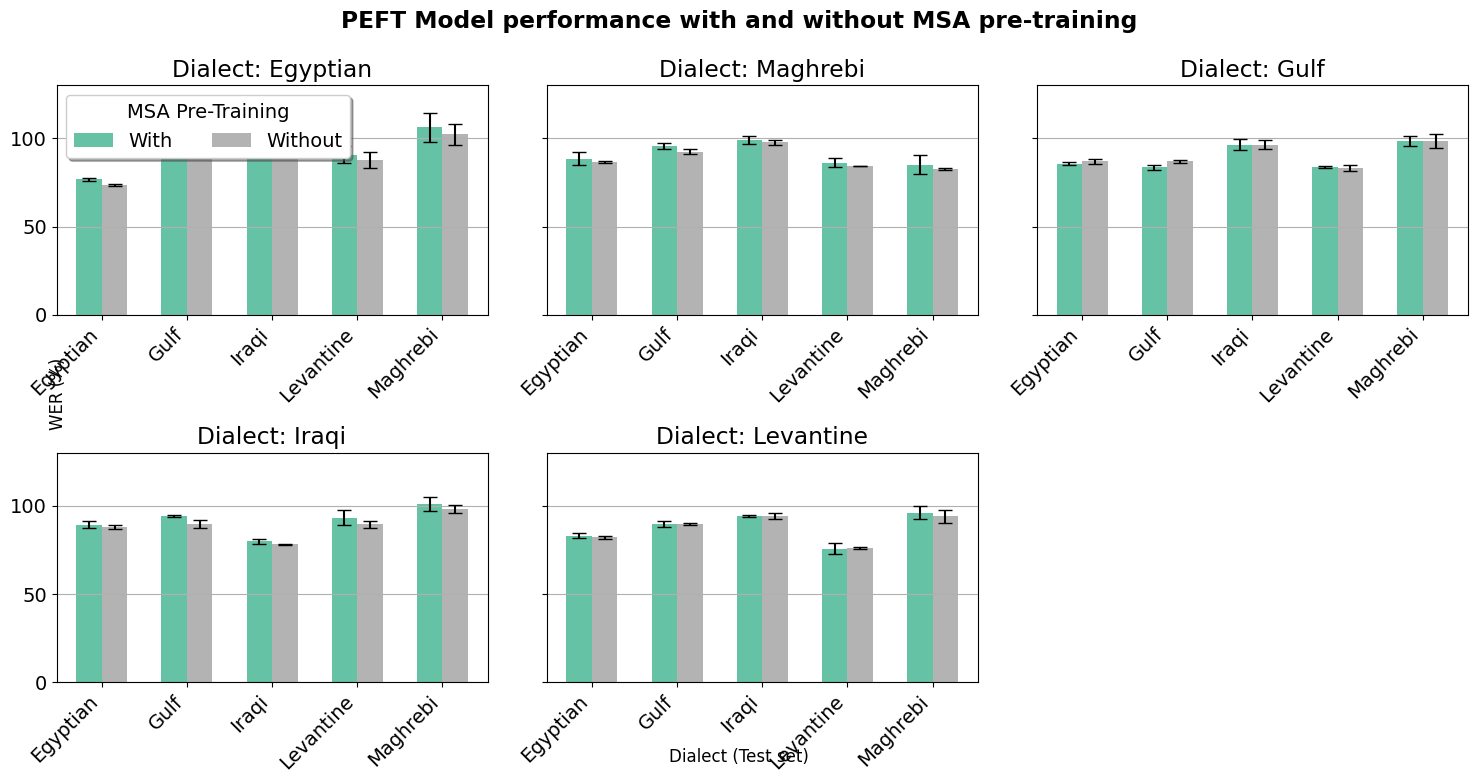

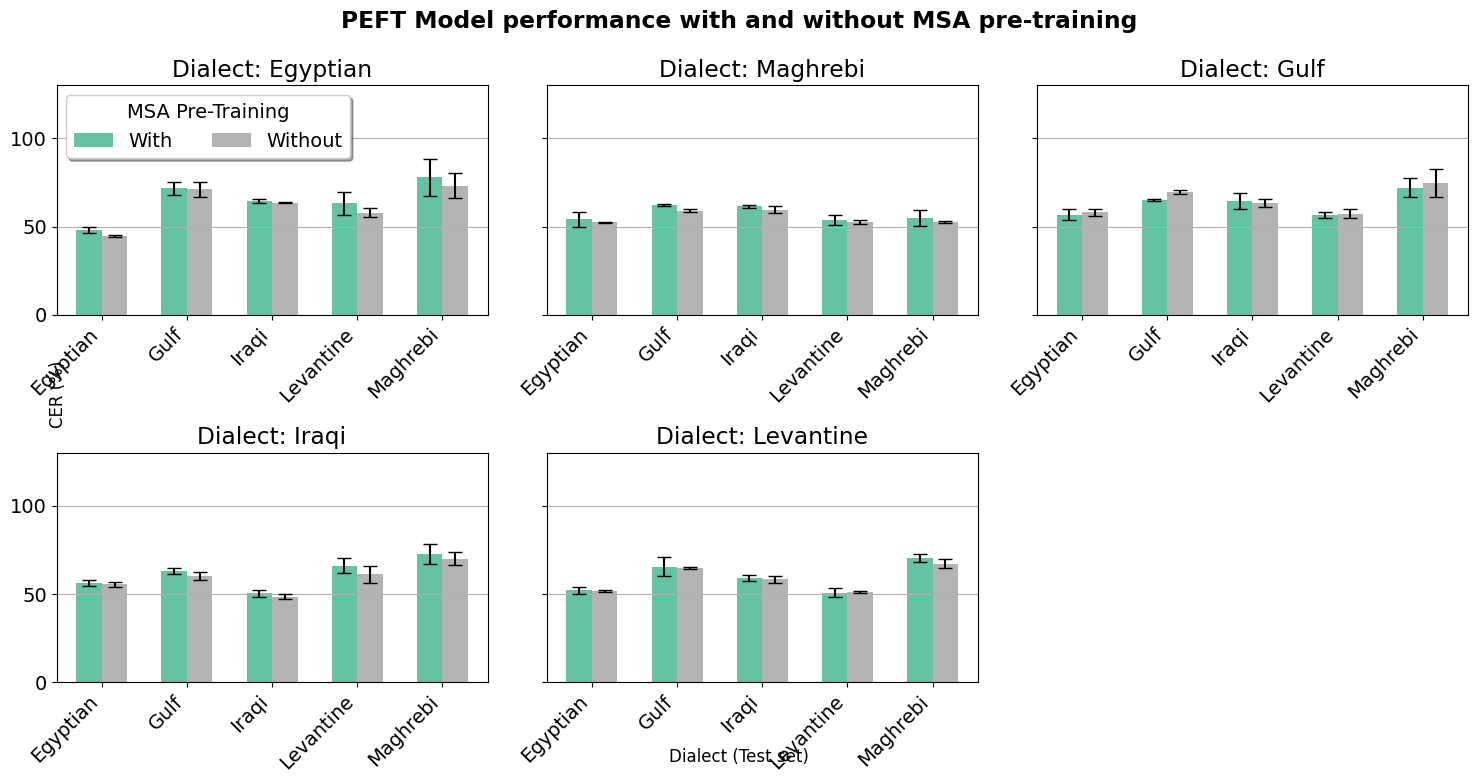

In [14]:
# Plot comparison between with and without MSA pre-training
if not df_peft_with_msa.empty and not df_peft_base_only.empty:
    for res in ["WER", "CER"]:
        available_dialects = list(set(df_peft_with_msa.columns).intersection(set(df_peft_base_only.columns)))
        available_dialects = [d for d in available_dialects if d in ['Egyptian', 'Gulf', 'Levantine', 'Maghrebi', 'Iraqi']]  # Added Iraqi
        
        if not available_dialects:
            print(f"No matching dialects found for {res} comparison")
            continue
            
        n_dialects = len(available_dialects)
        n_cols = 3  # Changed from 2 to 3 to better accommodate 5 dialects
        n_rows = (n_dialects + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharey=True)  # Increased width
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_dialects == 1:
            axes = axes.reshape(-1, 1)
        
        # Get consistent colors from Set2 colormap
        colors = plt.cm.Set2([0, 7])  # First two colors from Set2
        
        for i, dialect in enumerate(available_dialects):
            row = i // n_cols
            col = i % n_cols
            ax = axes[row, col] if n_rows > 1 or n_cols > 1 else axes
            
            try:
                # Check if we have data for this dialect and metric
                with_msa_available = False
                base_only_available = False
                
                # Check with MSA data
                try:
                    if (res, dialect) in df_peft_with_msa.index:
                        with_msa_data = df_peft_with_msa.loc[(res, dialect)]
                        if not with_msa_data.empty:
                            with_msa_available = True
                except:
                    pass
                
                # Check base only data
                try:
                    if (res, dialect) in df_peft_base_only.index:
                        base_only_data = df_peft_base_only.loc[(res, dialect)]
                        if not base_only_data.empty:
                            base_only_available = True
                except:
                    pass
                
                if not with_msa_available or not base_only_available:
                    ax.text(0.5, 0.5, f'No data for {dialect}', ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f"Dialect: {dialect}")
                    continue
                
                # Prepare data for this dialect
                df_new = pd.DataFrame({
                    "With": with_msa_data,
                    "Without": base_only_data
                }).fillna("N/A")
                
                # Extract numerical values
                def extract_values(series):
                    means, stds = [], []
                    for val in series:
                        if val == "N/A" or pd.isna(val):
                            means.append(np.nan)
                            stds.append(np.nan)
                        else:
                            try:
                                parts = str(val).split(' ± ')
                                means.append(float(parts[0]))
                                stds.append(float(parts[1]) if len(parts) > 1 else 0)
                            except:
                                means.append(np.nan)
                                stds.append(np.nan)
                    return pd.Series(means), pd.Series(stds)
                
                with_means, with_stds = extract_values(df_new["With"])
                without_means, without_stds = extract_values(df_new["Without"])
                
                # Plot settings
                x = np.arange(len(df_new.index))
                width = 0.3
                
                # Plot bars with error
                ax.bar(x - width/2, with_means, width, yerr=with_stds, 
                      capsize=5, color=colors[0], label='With')
                ax.bar(x + width/2, without_means, width, yerr=without_stds, 
                      capsize=5, color=colors[1], label='Without')
                
                ax.set_title(f"Dialect: {dialect}")
                ax.grid(True, axis='y')
                ax.set_xticks(x)
                ax.set_xticklabels(df_new.index, rotation=45, ha='right')
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"Dialect: {dialect}")
        
        # Hide unused subplots
        for i in range(len(available_dialects), n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            if n_rows > 1 or n_cols > 1:
                axes[row, col].set_visible(False)
        
        # Add legend to first subplot
        first_ax = axes[0, 0] if (n_rows > 1 or n_cols > 1) else axes
        first_ax.legend(ncol=2, fancybox=True, shadow=True, 
                       title="MSA Pre-Training", loc="upper left",
                       labels=["With", "Without"])
        
        # Labels
        fig.text(0.04, 0.5, f"{res} (%)", va='center', rotation='vertical', fontsize=12)
        fig.text(0.5, 0.04, "Dialect (Test set)", ha='center', fontsize=12)
        
        plt.ylim(bottom=0, top=130)
        fig.suptitle("PEFT Model performance with and without MSA pre-training", 
                    fontweight='bold')
        plt.tight_layout()
        
        plt.savefig(f"peft_comparison_{res.lower()}.pdf")
        plt.show()
else:
    print("Cannot create comparison plots - missing data")

## Statistical tests

In [15]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Load raw data for statistical tests
def load_peft_raw_data(notebook_path, with_msa=True):
    """Load raw numerical data for statistical analysis"""
    dialects = ['egyptian', 'gulf', 'levantine', 'maghrebi', 'iraqi']  # Added iraqi dialect
    all_results = []
    
    for dialect in dialects:
        dialect_path = os.path.join(notebook_path, f"{dialect}_results")
        if not os.path.exists(dialect_path):
            continue
            
        model_suffix = f"{dialect}-msa" if with_msa else f"{dialect}-base"
        
        for seed in [42, 84, 168]:
            result_file = f"results_whisper-small-peft_{model_suffix}_seed{seed}.json"
            result_path = os.path.join(dialect_path, result_file)
            
            if os.path.exists(result_path):
                with open(result_path, 'r') as f:
                    data = json.load(f)
                    all_results.append({
                        'dialect': dialect,
                        'seed': seed,
                        'wer': data['wer'],
                        'cer': data['cer']
                    })
    
    return pd.DataFrame(all_results)

# Load raw data
base_only_raw = load_peft_raw_data("notebook", with_msa=False)
with_msa_raw = load_peft_raw_data("notebook", with_msa=True)

print("Base-only raw data:")
print(base_only_raw.head())
print("\nWith MSA raw data:")
print(with_msa_raw.head())

if not base_only_raw.empty and not with_msa_raw.empty:
    # Merge data for comparison
    comparison_data = []
    
    for dialect in base_only_raw['dialect'].unique():
        base_dialect_data = base_only_raw[base_only_raw['dialect'] == dialect]
        msa_dialect_data = with_msa_raw[with_msa_raw['dialect'] == dialect]
        
        if not base_dialect_data.empty and not msa_dialect_data.empty:
            # Wilcoxon test for WER
            base_wer = base_dialect_data['wer'].values
            msa_wer = msa_dialect_data['wer'].values
            
            if len(base_wer) > 0 and len(msa_wer) > 0:
                try:
                    if len(base_wer) == len(msa_wer) and len(base_wer) >= 3:
                        z_val, p_val = stats.wilcoxon(base_wer, msa_wer)
                    else:
                        # Use Mann-Whitney U test if sample sizes are different
                        z_val, p_val = stats.mannwhitneyu(base_wer, msa_wer, alternative='two-sided')
                except Exception as e:
                    print(f"Statistical test failed for {dialect}: {e}")
                    z_val, p_val = np.nan, np.nan
                    
                comparison_data.append({
                    'dialect': dialect.title(),
                    'base_mean': base_wer.mean(),
                    'base_std': base_wer.std(),
                    'msa_mean': msa_wer.mean(),
                    'msa_std': msa_wer.std(),
                    'z_value': z_val,
                    'p_value': p_val
                })
    
    if comparison_data:
        test_df = pd.DataFrame(comparison_data)
        test_df.set_index('dialect', inplace=True)
        
        # Multiple testing correction
        valid_p_values = test_df['p_value'].dropna()
        if len(valid_p_values) > 0:
            corrected_p = multipletests(valid_p_values, method='holm')[1]
            # Initialize holm_bonferroni column with NaN
            test_df['holm_bonferroni'] = np.nan
            test_df.loc[valid_p_values.index, 'holm_bonferroni'] = corrected_p
        else:
            test_df['holm_bonferroni'] = np.nan
        
        # Format for display
        test_df['Base-only training'] = test_df.apply(
            lambda row: f"{row['base_mean']:.2f} ± {row['base_std']:.2f}", axis=1
        )
        test_df['With MSA pre-training'] = test_df.apply(
            lambda row: f"{row['msa_mean']:.2f} ± {row['msa_std']:.2f}", axis=1
        )
        
        # Select columns for final display
        final_df = test_df[['Base-only training', 'With MSA pre-training', 'z_value', 'p_value', 'holm_bonferroni']].round(3)
        final_df.columns = ['Base-only training', 'With MSA pre-training', 'Z-statistic', 'p-value', 'holm-bonferroni']
        
        final_df.to_latex("peft_statistical_tests.tex", bold_rows=True, 
                         caption="Wilcoxon results comparing PEFT models with and without MSA pre-training", 
                         label="tab:peft_ttest", float_format="%.3f")
        
        display(final_df)
    else:
        print("No comparison data available")
else:
    print("Could not load raw data for statistical tests")

Base-only raw data:
    dialect  seed        wer        cer
0  egyptian    42  73.111537  45.233126
1  egyptian    84  73.728841  44.692018
2  egyptian   168  74.043991  44.224641
3      gulf    42  86.152145  70.813899
4      gulf    84  87.976296  68.936930

With MSA raw data:
    dialect  seed        wer        cer
0  egyptian    42  77.309204  47.451294
1  egyptian    84  77.263719  49.917522
2  egyptian   168  75.960882  47.067645
3      gulf    42  82.857932  64.216545
4      gulf    84  85.286622  64.838306


,Base-only training,With MSA pre-training,Z-statistic,p-value,holm-bonferroni
dialect,,,,,
Egyptian,73.63 ± 0.39,76.84 ± 0.63,0.0,0.25,1.0
Gulf,86.93 ± 0.77,83.55 ± 1.24,0.0,0.25,1.0
Levantine,76.07 ± 0.52,75.80 ± 2.50,3.0,1.00,1.0
Maghrebi,82.53 ± 0.51,85.14 ± 4.56,2.0,0.75,1.0
Iraqi,78.26 ± 0.29,79.82 ± 1.20,0.0,0.25,1.0


# Experiment 3: Dialectal Arabic Fine-Tuning (PEFT Models)

In [16]:
# Calculate cross-dialect performance averages
if not df_peft_with_msa.empty:
    available_dialects = [col for col in df_peft_with_msa.columns if col in ['Egyptian', 'Gulf', 'Levantine', 'Maghrebi', 'Iraqi']]  # Added Iraqi
    
    for dialect in available_dialects:
        try:
            if ('WER', dialect) in df_peft_with_msa.index:
                # Get WER results for this dialect trained model tested on other dialects
                cross_dialect_cols = [col for col in available_dialects if col != dialect]
                
                if cross_dialect_cols:
                    cross_dialect_data = df_peft_with_msa.loc[('WER', dialect), cross_dialect_cols]
                    
                    # Extract numerical values from "mean ± std" format
                    numerical_values = []
                    for val in cross_dialect_data:
                        try:
                            if pd.notna(val) and '±' in str(val):
                                mean_val = float(str(val).split(' ± ')[0])
                                numerical_values.append(mean_val)
                        except:
                            continue
                    
                    if numerical_values:
                        avg_cross_dialect = np.mean(numerical_values)
                        print(f"{dialect}: Average cross-dialect WER = {avg_cross_dialect:.2f}%")
                    else:
                        print(f"{dialect}: No valid cross-dialect data")
                else:
                    print(f"{dialect}: No other dialects available for comparison")
            else:
                print(f"{dialect}: No WER data available")
        except Exception as e:
            print(f"{dialect}: Error processing data - {str(e)}")
else:
    print("No data available for cross-dialect analysis")

Egyptian: Average cross-dialect WER = 99.11%
Gulf: Average cross-dialect WER = 91.09%
Iraqi: Average cross-dialect WER = 94.46%
Levantine: Average cross-dialect WER = 90.85%
Maghrebi: Average cross-dialect WER = 92.36%


In [19]:
def plot_peft_cm(df, metric, pretraining, title_suffix=""):
    """
    Plot confusion matrix style heatmap for PEFT results
    """
    if df.empty:
        print(f"No data available for {metric} confusion matrix ({pretraining})")
        return
        
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    try:
        # Get data for the specific metric
        metric_indices = [idx for idx in df.index if idx[0] == metric]
        if not metric_indices:
            print(f"No {metric} data found")
            return
            
        # Extract data for this metric
        metric_data = df.loc[metric_indices]
        
        # Convert "mean ± std" format to separate mean and std matrices
        mean_matrix = pd.DataFrame(index=metric_data.index.get_level_values(1), columns=metric_data.columns)
        std_matrix = pd.DataFrame(index=metric_data.index.get_level_values(1), columns=metric_data.columns)
        
        for idx in metric_data.index:
            model = idx[1]
            for col in metric_data.columns:
                val = metric_data.loc[idx, col]
                if pd.notna(val) and '±' in str(val):
                    parts = str(val).split(' ± ')
                    mean_matrix.loc[model, col] = float(parts[0])
                    std_matrix.loc[model, col] = float(parts[1]) if len(parts) > 1 else 0
                else:
                    mean_matrix.loc[model, col] = np.nan
                    std_matrix.loc[model, col] = np.nan
        
        # Create combined annotations
        annot_matrix = pd.DataFrame(index=mean_matrix.index, columns=mean_matrix.columns)
        for idx in mean_matrix.index:
            for col in mean_matrix.columns:
                mean_val = mean_matrix.loc[idx, col]
                std_val = std_matrix.loc[idx, col]
                if pd.notna(mean_val) and pd.notna(std_val):
                    annot_matrix.loc[idx, col] = f"{mean_val:.1f}\n(± {std_val:.1f})"
                else:
                    annot_matrix.loc[idx, col] = "N/A"
        
        # Plot heatmap
        sns.heatmap(mean_matrix.astype(float), 
                    annot=annot_matrix, 
                    cmap='viridis_r', 
                    fmt='',
                    cbar=True, 
                    ax=ax,
                    cbar_kws={'label': f'{metric} (%)'})
        
        plt.title(f"Model performance in {metric} (%) {pretraining} MSA pre-training{title_suffix}")
        plt.ylabel("Dialect fine-tuned on")
        plt.xlabel("Dialect tested on")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        suffix = "with_msa" if pretraining == "with" else "base_only"
        plt.savefig(f"peft_{suffix}_cm_{metric.lower()}.pdf")
        plt.show()
        
    except Exception as e:
        print(f"Error creating confusion matrix for {metric} ({pretraining}): {str(e)}")
        ax.text(0.5, 0.5, f'Error: {str(e)[:100]}...', ha='center', va='center', transform=ax.transAxes)
        plt.show()

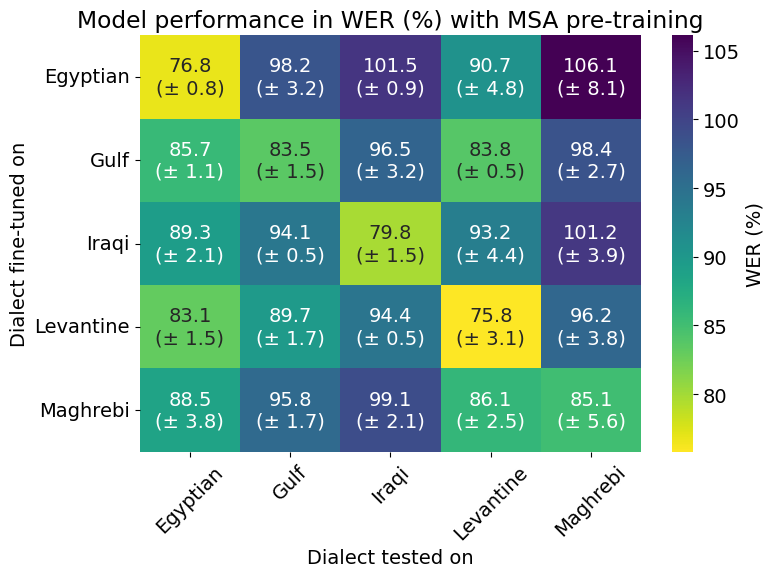

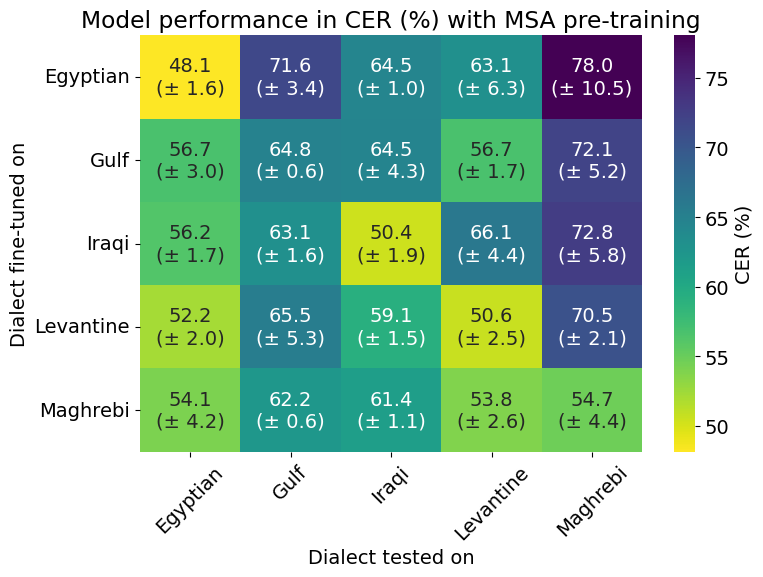

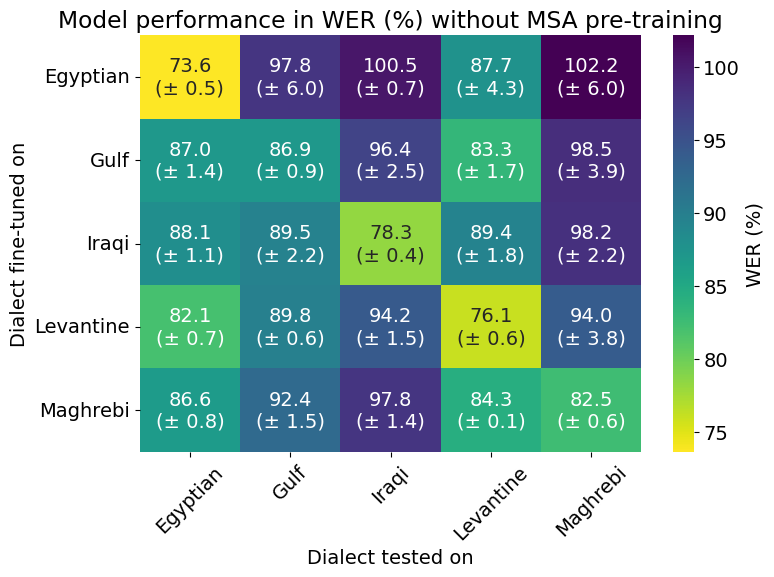

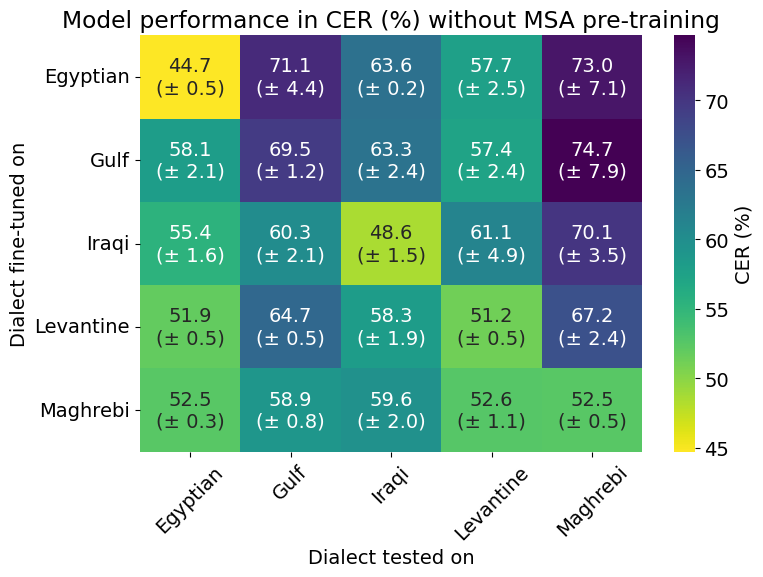

In [20]:
# Plot confusion matrices for PEFT models
if not df_peft_with_msa.empty:
    plot_peft_cm(df_peft_with_msa, "WER", "with")
    plot_peft_cm(df_peft_with_msa, "CER", "with")
else:
    print("No with-MSA data for confusion matrices")

if not df_peft_base_only.empty:
    plot_peft_cm(df_peft_base_only, "WER", "without")
    plot_peft_cm(df_peft_base_only, "CER", "without")
else:
    print("No base-only data for confusion matrices")

In [12]:
def plot_peft_results(df, title, filename):
    """
    Plot bar charts for PEFT results with error bars
    """
    if df.empty:
        print(f"No data available for {title}")
        return
        
    fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True, sharey=False)
    
    for i, res in enumerate(["WER", "CER"]):
        try:
            # Get data for this metric
            metric_indices = [idx for idx in df.index if idx[0] == res]
            if not metric_indices:
                ax[i].text(0.5, 0.5, f'No {res} data available', ha='center', va='center', transform=ax[i].transAxes)
                continue
                
            metric_data = df.loc[metric_indices]
            
            # Convert "mean ± std" to separate mean and std DataFrames
            mean_data = pd.DataFrame(index=metric_data.index.get_level_values(1), columns=metric_data.columns)
            std_data = pd.DataFrame(index=metric_data.index.get_level_values(1), columns=metric_data.columns)
            
            for idx in metric_data.index:
                model = idx[1]
                for col in metric_data.columns:
                    val = metric_data.loc[idx, col]
                    if pd.notna(val) and '±' in str(val):
                        parts = str(val).split(' ± ')
                        mean_data.loc[model, col] = float(parts[0])
                        std_data.loc[model, col] = float(parts[1]) if len(parts) > 1 else 0
                    else:
                        mean_data.loc[model, col] = np.nan
                        std_data.loc[model, col] = np.nan
            
            # Plot bars with error bars
            mean_data = mean_data.astype(float)
            std_data = std_data.astype(float)
            
            axes = mean_data.plot(kind='bar', ax=ax[i], colormap='Set2', rot=0,
                                 yerr=std_data, error_kw={'elinewidth': 1, 'capthick': 1}, capsize=2)
            
            ax[i].set_ylabel(f"{res} (%)")
            ax[i].set_ylim(0, 120 + 40 * (i == 0))
            ax[i].set_yticks(np.arange(0, 120 + 40 * (i == 0), 20))
            ax[i].grid(axis='y')
            
            # Add hatches to bars where model tests on itself
            for g in axes.containers:
                g_label = g.get_label()
                for j, child in enumerate(g.get_children()):
                    if j < len(mean_data.index):
                        bar_name = mean_data.iloc[j].name
                        if bar_name == g_label:
                            child.set(hatch='//')
                            
        except Exception as e:
            ax[i].text(0.5, 0.5, f'Error: {str(e)[:50]}...', ha='center', va='center', transform=ax[i].transAxes)

    ax[1].set_xlabel("Dialect(s) trained on")
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.02), ncol=1, 
                fancybox=True, shadow=True, title="Test set")
    ax[1].legend().remove()
    fig.suptitle(title, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

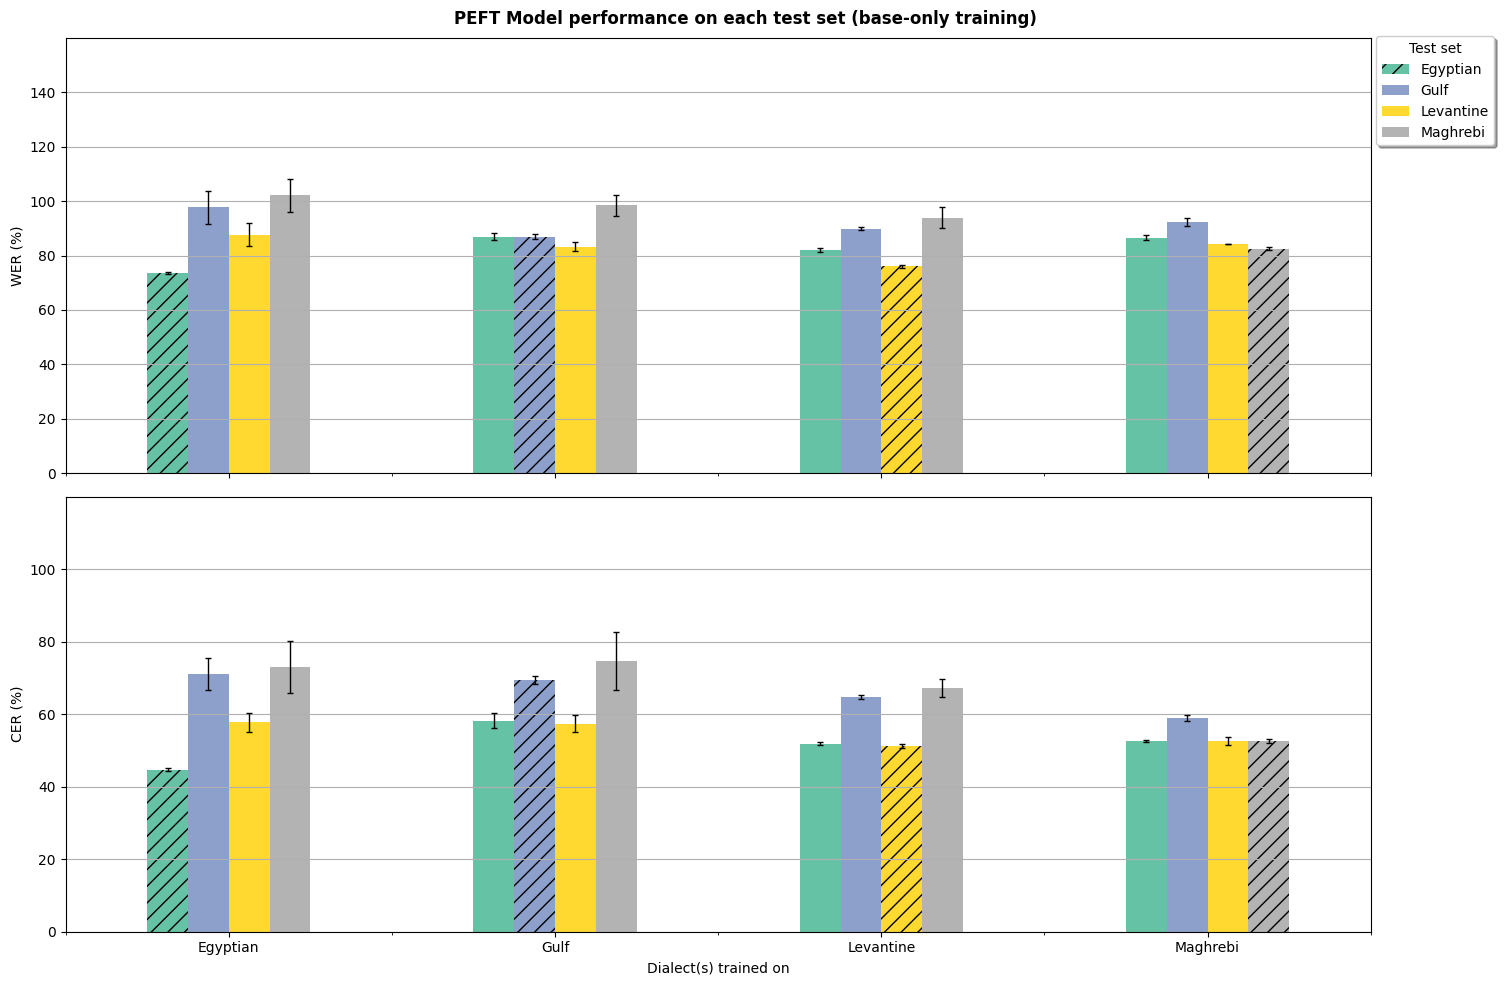

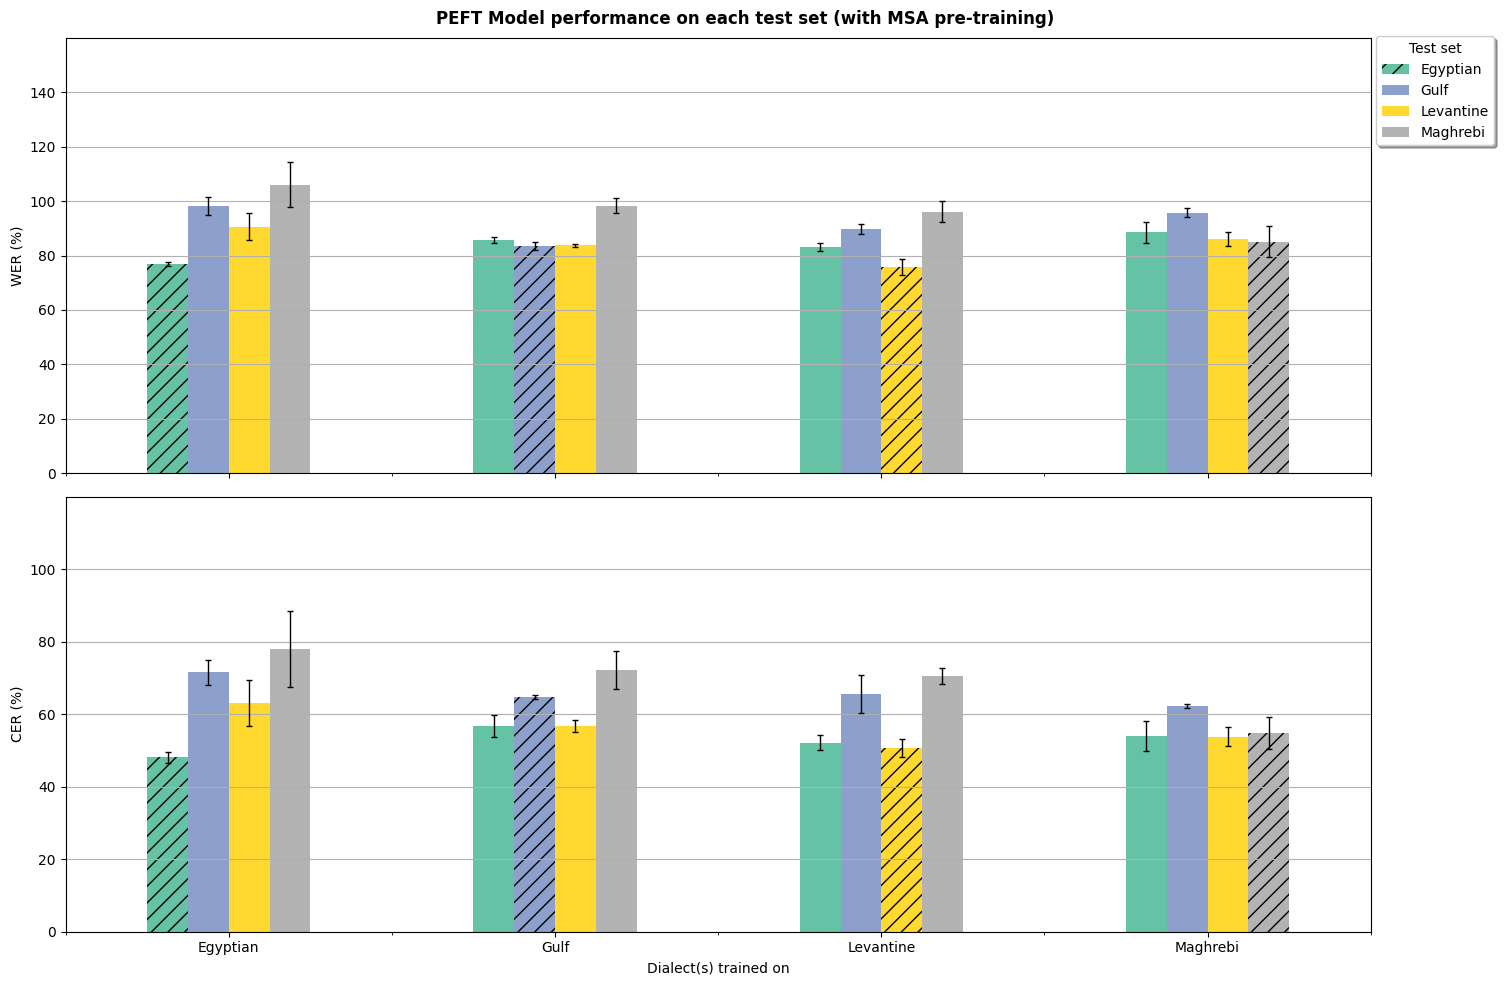

In [14]:
# Plot PEFT results
if not df_peft_base_only.empty:
    plot_peft_results(df_peft_base_only, 
                     "PEFT Model performance on each test set (base-only training)", 
                     "peft_base_only.pdf")
else:
    print("No base-only data for plotting")

if not df_peft_with_msa.empty:
    plot_peft_results(df_peft_with_msa, 
                     "PEFT Model performance on each test set (with MSA pre-training)", 
                     "peft_with_msa.pdf")
else:
    print("No with-MSA data for plotting")